In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
print(tf.__version__)

start = time.time()

2.8.0


In [2]:
train_dir = '/home/ras/Downloads/Powerlines/training'
validation_dir = '/home/ras/Downloads/Powerlines/validation'

print(train_dir)

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


/home/ras/Downloads/Powerlines/training
Found 160 files belonging to 2 classes.
Found 52 files belonging to 2 classes.


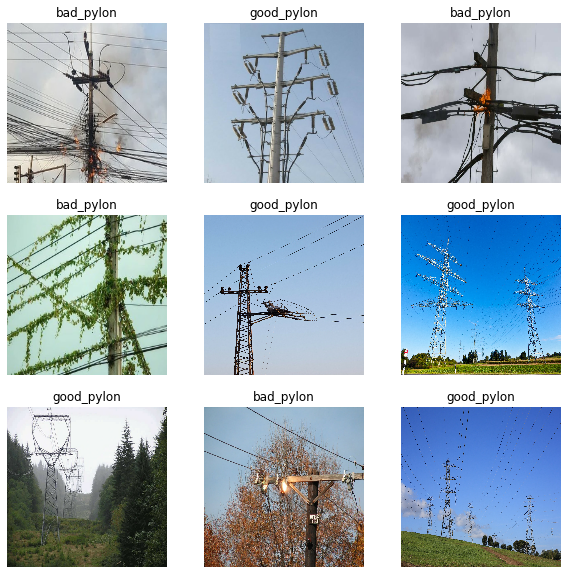

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 5
Number of test batches: 1


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

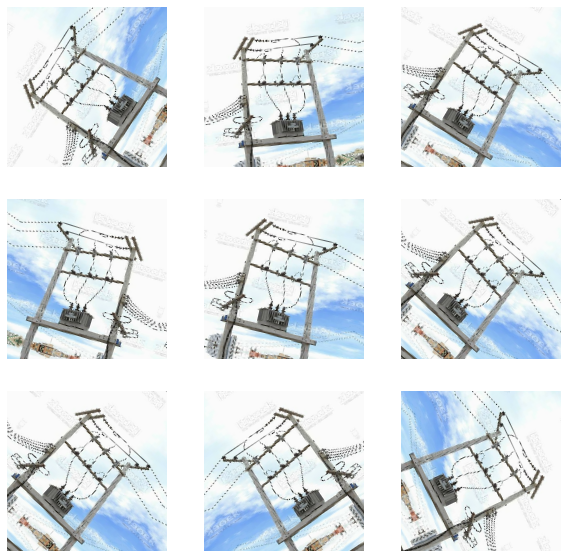

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 5, 5, 2048)


In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 40, 40, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 40, 40, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 40, 40, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 40, 40, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 20, 20, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 20, 20, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 20, 20, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 20, 20, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 21s 2s/step - loss: 1.4360 - accuracy: 0.5000


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

initial loss: 1.44
initial accuracy: 0.50
68.45 seconds have passed since start


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

Epoch 1/20
16/16 [==============================] - 78s 4s/step - loss: 1.2701 - accuracy: 0.4187 - val_loss: 0.9523 - val_accuracy: 0.4048
Epoch 2/20
16/16 [==============================] - 73s 4s/step - loss: 1.0915 - accuracy: 0.4500 - val_loss: 0.9671 - val_accuracy: 0.4286
Epoch 3/20
16/16 [==============================] - 75s 4s/step - loss: 0.9321 - accuracy: 0.5375 - val_loss: 0.7808 - val_accuracy: 0.5476
Epoch 4/20
16/16 [==============================] - 78s 5s/step - loss: 1.0539 - accuracy: 0.4375 - val_loss: 0.7792 - val_accuracy: 0.5000
Epoch 5/20
16/16 [==============================] - 76s 4s/step - loss: 0.9456 - accuracy: 0.4812 - val_loss: 0.6990 - val_accuracy: 0.6190
Epoch 6/20
16/16 [==============================] - 75s 4s/step - loss: 0.8966 - accuracy: 0.5125 - val_loss: 0.6286 - val_accuracy: 0.6429
Epoch 7/20
16/16 [==============================] - 74s 4s/step - loss: 0.7363 - accuracy: 0.6125 - val_loss: 0.6209 - val_accuracy: 0.6190
Epoch 8/20
16/16 [==

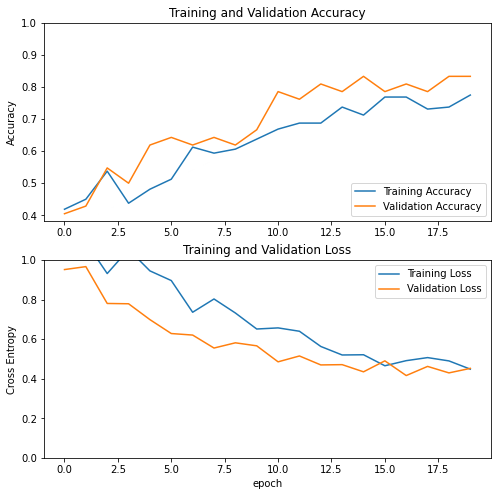

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
len(model.trainable_variables)
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

1705.14 seconds have passed since start


In [27]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

Epoch 20/40
16/16 [==============================] - 161s 9s/step - loss: 0.4323 - accuracy: 0.7875 - val_loss: 0.5572 - val_accuracy: 0.7381
Epoch 21/40
16/16 [==============================] - 129s 8s/step - loss: 0.2685 - accuracy: 0.8750 - val_loss: 0.6178 - val_accuracy: 0.7381
Epoch 22/40
16/16 [==============================] - 142s 9s/step - loss: 0.2337 - accuracy: 0.8938 - val_loss: 0.6854 - val_accuracy: 0.7143
Epoch 23/40
16/16 [==============================] - 134s 8s/step - loss: 0.1737 - accuracy: 0.9375 - val_loss: 0.7885 - val_accuracy: 0.7381
Epoch 24/40
16/16 [==============================] - 139s 9s/step - loss: 0.1102 - accuracy: 0.9500 - val_loss: 1.0588 - val_accuracy: 0.7381
Epoch 25/40
16/16 [==============================] - 144s 9s/step - loss: 0.1045 - accuracy: 0.9625 - val_loss: 0.9245 - val_accuracy: 0.7143
Epoch 26/40
16/16 [==============================] - 137s 8s/step - loss: 0.0521 - accuracy: 0.9812 - val_loss: 1.1576 - val_accuracy: 0.6905
Epoch 

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

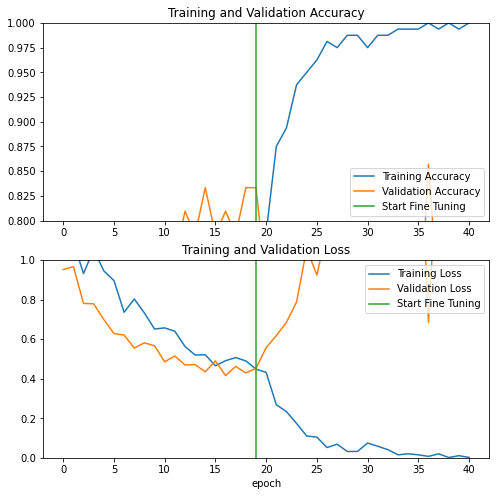

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 10s 10s/step - loss: 1.3231 - accuracy: 0.8000
Test accuracy : 0.800000011920929


Predictions:
 [1 1 1 1 1 1 1 0 1 1]
Labels:
 [1 0 1 0 1 1 0 0 1 1]
4917.32 seconds have passed since start


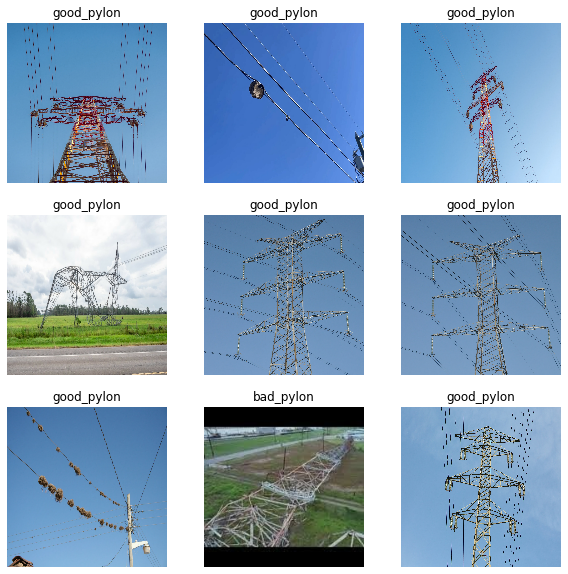

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
    
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
